In [ ]:
import pickle
#with open("all_ef_df_1.pickle","wb") as file:
#  pickle.dump(all_ef_df,file)
with open("all_ef_df_1.pickle","rb") as file:
  all_ef_df = pickle.load(file)
all_ef_df["page"] = all_ef_df.page+1  

In [ ]:
all_ef_df.head()

,vol_id,page,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman
0,chi.40727635,1,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
1,chi.40727635,2,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
2,chi.40727635,3,0,0,0,0,0,0,0.000000,0.000000,0.000,0.000
3,chi.40727635,4,1,1,0,1,0,1,0.000000,1.000000,0.000,1.000
4,chi.40727635,5,18,40,0,18,11,4,0.611111,0.222222,0.625,0.875


In [ ]:
X_test2 = all_ef_df.loc[:,["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]].to_numpy()

In [ ]:
all_ef_df

,vol_id,page,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman
0,chi.40727635,1,1,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000
1,chi.40727635,2,1,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000
2,chi.40727635,3,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
3,chi.40727635,4,1,1,0,1,0,1,0.000000,1.000000,0.000000,1.000000
4,chi.40727635,5,18,40,0,18,11,4,0.611111,0.222222,0.625000,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...
19179,wu.89011485885,18,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
19180,wu.89011485885,19,6,48,0,6,1,1,0.166667,0.166667,0.000000,0.812500
19181,wu.89011485885,20,1,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000
19182,wu.89011485885,21,30,292,0,30,9,1,0.300000,0.033333,0.006849,0.592466


In [ ]:
import pandas as pd
# read dataset
x_fact_all = pd.read_csv("../FrontmatterData.tsv",sep="\t",header=None)

In [ ]:
x_fact_all.head()

,0,1
0,chi.40727635,"[[""no_content"",""no_content"",""""],[""no_content"",..."
1,coo.31924000431662,"[[""no_content"",""no_content"",""""],[""no_content"",..."
2,coo.31924001144959,"[[""no_content"",""no_content"",""binding""],[""no_co..."
3,coo.31924073896007,"[[""factual"",""cover"",""""],[""no_content"",""no_cont..."
4,coo.31924080009719,"[[""mixed"",""cover"",""cover art photo""],[""mixed"",..."


The data is completely differnet than the frontmatter analysis, so I need to get the extracted feature data from HTRC

In [ ]:
len(x_fact_all[0].values)

900

In [ ]:
x_fact_page = []

In [ ]:
import json
for val in x_fact_all.values:
  dump_val = json.loads(val[1])
  #print(dump_val)
  for i,page in enumerate(dump_val):
    temp = [val[0],i]
    #print(page)
    temp.extend(page)
    x_fact_page.append(temp)

In [ ]:
x_fact_page_df = pd.DataFrame(x_fact_page,columns=["vol_id","page","type","sub_type","add"])
x_fact_page_df["page"] = x_fact_page_df["page"] + 1

In [ ]:
x_fact_page_df.head()

,vol_id,page,type,sub_type,add
0,chi.40727635,1,no_content,no_content,
1,chi.40727635,2,no_content,no_content,stamp
2,chi.40727635,3,no_content,no_content,
3,chi.40727635,4,no_content,no_content,
4,chi.40727635,5,factual,title,


In [ ]:
tt = x_fact_page_df.merge(all_ef_df,left_on=["vol_id","page"],right_on=["vol_id","page"])

In [ ]:
tt.shape

(17456, 15)

In [ ]:
tt.loc[tt.type=="mixed","type"] = "creative"

In [ ]:
type_list = tt.type.unique().tolist()
tt["type_label"] = tt.type.apply(lambda x:type_list.index(x))

In [ ]:
tt

,vol_id,page,type,sub_type,add,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman,type_label
0,chi.40727635,1,no_content,no_content,,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000000,0
1,chi.40727635,2,no_content,no_content,stamp,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000000,0
2,chi.40727635,3,no_content,no_content,,0,0,0,0,0,0,0.000000,0.000000,0.000,0.000000,0
3,chi.40727635,4,no_content,no_content,,1,1,0,1,0,1,0.000000,1.000000,0.000,1.000000,0
4,chi.40727635,5,factual,title,,18,40,0,18,11,4,0.611111,0.222222,0.625,0.875000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17451,wu.89011485885,16,creative,main_text,,23,179,0,23,6,1,0.260870,0.043478,0.000,0.675978,2
17452,wu.89011485885,17,creative,image,,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000000,2
17453,wu.89011485885,18,no_content,no_content,,0,0,0,0,0,0,0.000000,0.000000,0.000,0.000000,0
17454,wu.89011485885,19,creative,epigraph,,6,48,0,6,1,1,0.166667,0.166667,0.000,0.812500,2


In [ ]:
tt.vol_id.unique().shape

(875,)

In [ ]:
import random
random.seed(7)

# random cross validation on the volume
list_train = []
vol_list = tt.vol_id.unique().tolist()
for i in range(10):
  vol_train = random.sample(vol_list,int(len(vol_list)*.8))
  list_train.append(vol_train)

In [ ]:
import tqdm

list_model_rf = []
list_model_sgd = []
list_model_svm = []
list_model_logres = []
for vol_train in tqdm.tqdm(list_train):
  X_train2 = tt[tt.vol_id.isin(vol_train)]
  y_train2 = X_train2.type_label.values
  X_train2 = X_train2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]].to_numpy()
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  X_test2 = X_test2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]].to_numpy()

  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                                random_state=0)
  clf_rf.fit(X_train2, y_train2)  
  y_hat = clf_rf.predict(X_test2)
  #metrics.accuracy_score(y_test2,y_hat)
  #print(metrics.classification_report(y_test,y_hat,target_names=type_index))  
  
  #list_model_rf.append((clf_rf,y_hat))
  x_local = tt[tt.vol_id.isin(vol_train)==False].copy()
  x_local["y_hat"] = y_hat
  list_model_rf.append((clf_rf,y_hat,x_local))

  continue

  from sklearn.svm import LinearSVC
  clf_svm_linear = LinearSVC(random_state=0, tol=1e-6,max_iter=10000)
  clf_svm_linear.fit(X_train2, y_train2)   

  y_hat = clf_svm_linear.predict(X_test2)
  list_model_svm.append((clf_svm_linear,y_hat))

  from sklearn.linear_model import SGDClassifier
  sgd_classifier = SGDClassifier(random_state=0, tol=1e-7,max_iter=10000)
  sgd_classifier.fit(X_train2, y_train2)  

  y_hat = sgd_classifier.predict(X_test2)
  list_model_sgd.append((sgd_classifier,y_hat))


  from sklearn.linear_model import LogisticRegression

  # logistic regression
  clf_lr = LogisticRegression()
  clf_lr.fit(X_train2, y_train2)
  y_hat = clf_lr.predict(X_test2)
  list_model_logres.append((clf_lr,y_hat))

  #print(clf_rf.feature_importances_)

100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


In [ ]:
with open("all_model_baeline.pickle","wb") as file:
  pickle.dump((list_model_rf,list_model_svm,list_model_sgd,list_model_logres),file)

In [ ]:
%%script false
metrics.f1_score(y_test2,x[1],average="weighted")

In [ ]:
%%script false
import io
data = io.StringIO(metrics.classification_report(y_test2,x[1]))
pd.read_csv(data,sep="\t")

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
from sklearn import metrics

for i,(vol_train,x) in enumerate(zip(list_train,list_model_svm)):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  if i == 0:
    cnf_matrix = confusion_matrix(y_test2,x[1])
  else:
    cnf_matrix += confusion_matrix(y_test2,x[1])
  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1016
           1       0.80      0.75      0.77       992
           2       0.87      0.90      0.88      1472

    accuracy                           0.85      3480
   macro avg       0.85      0.84      0.85      3480
weighted avg       0.85      0.85      0.85      3480

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       952
           1       0.76      0.72      0.74       994
           2       0.86      0.86      0.86      1534

    accuracy                           0.83      3480
   macro avg       0.82      0.82      0.82      3480
weighted avg       0.82      0.83      0.83      3480

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1029
           1       0.80      0.61      0.69      1013
           2       0.80      0.90      0.85      1458

    accuracy        

Normalized confusion matrix


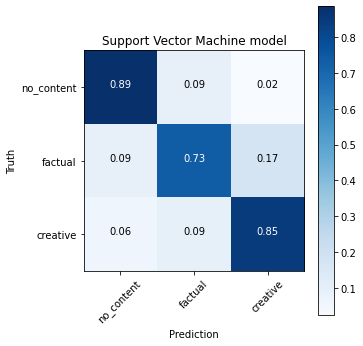

In [ ]:
import numpy as np
#cnf_matrix = confusion_matrix(y_test3,y_hat3)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=tt.type.unique().tolist(), normalize=True,
                      title="{} model".format("Support Vector Machine"))
#plt.savefig("svm-normal.pdf",bbox_inches="tight")

In [ ]:
for i,(vol_train,x) in enumerate(zip(list_train,list_model_rf)):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  if i == 0:
    cnf_matrix = confusion_matrix(y_test2,x[1])
  else:
    cnf_matrix += confusion_matrix(y_test2,x[1])
  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1016
           1       0.85      0.80      0.83       992
           2       0.89      0.91      0.90      1472

    accuracy                           0.88      3480
   macro avg       0.88      0.88      0.88      3480
weighted avg       0.88      0.88      0.88      3480

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       952
           1       0.82      0.81      0.82       994
           2       0.90      0.88      0.89      1534

    accuracy                           0.87      3480
   macro avg       0.86      0.87      0.86      3480
weighted avg       0.87      0.87      0.87      3480

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1029
           1       0.84      0.77      0.81      1013
           2       0.88      0.88      0.88      1458

    accuracy        

Normalized confusion matrix


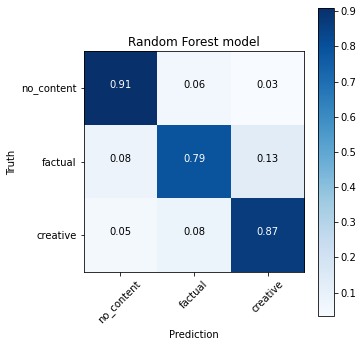

In [ ]:
import numpy as np
#cnf_matrix = confusion_matrix(y_test3,y_hat3)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=tt.type.unique().tolist(), normalize=True,
                      title="{} model".format("Random Forest"))
plt.savefig("rf-normal.pdf",bbox_inches="tight")

In [ ]:
for i,(vol_train,x) in enumerate(zip(list_train,list_model_logres)):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values

  if i == 0:
    cnf_matrix = confusion_matrix(y_test2,x[1])
  else:
    cnf_matrix += confusion_matrix(y_test2,x[1])

  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1016
           1       0.83      0.70      0.76       992
           2       0.91      0.87      0.89      1472

    accuracy                           0.84      3480
   macro avg       0.84      0.84      0.83      3480
weighted avg       0.85      0.84      0.84      3480

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       952
           1       0.81      0.73      0.76       994
           2       0.91      0.83      0.87      1534

    accuracy                           0.83      3480
   macro avg       0.82      0.83      0.82      3480
weighted avg       0.84      0.83      0.83      3480

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1029
           1       0.82      0.68      0.74      1013
           2       0.91      0.84      0.87      1458

    accuracy        

Normalized confusion matrix


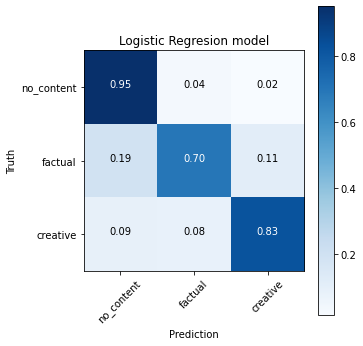

In [ ]:
import numpy as np
#cnf_matrix = confusion_matrix(y_test3,y_hat3)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=tt.type.unique().tolist(), normalize=True,
                      title="{} model".format("Logistic Regresion"))
plt.savefig("logres-normal.pdf",bbox_inches="tight")


In [ ]:
for i,(vol_train,x) in enumerate(zip(list_train,list_model_sgd)):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  if i == 0:
    cnf_matrix = confusion_matrix(y_test2,x[1])
  else:
    cnf_matrix += confusion_matrix(y_test2,x[1])
  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1016
           1       0.79      0.82      0.81       992
           2       0.88      0.88      0.88      1472

    accuracy                           0.86      3480
   macro avg       0.86      0.86      0.86      3480
weighted avg       0.86      0.86      0.86      3480

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       952
           1       0.82      0.67      0.74       994
           2       0.81      0.90      0.85      1534

    accuracy                           0.83      3480
   macro avg       0.83      0.81      0.82      3480
weighted avg       0.83      0.83      0.82      3480

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1029
           1       0.80      0.74      0.76      1013
           2       0.79      0.90      0.84      1458

    accuracy        

Normalized confusion matrix


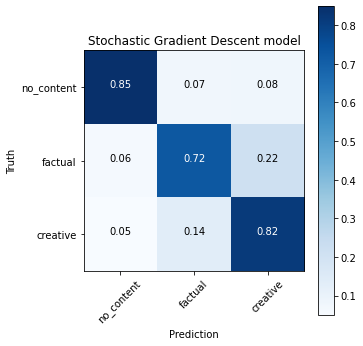

In [ ]:
import numpy as np
#cnf_matrix = confusion_matrix(y_test3,y_hat3)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=tt.type.unique().tolist(), normalize=True,
                      title="{} model".format("Stochastic Gradient Descent"))
plt.savefig("sgd-normal.pdf",bbox_inches="tight")


In [ ]:
import pandas as pd
result_pd = pd.read_csv("result_all.txt",sep="\t",header=None)

In [ ]:
ttx = result_pd.groupby([0,1]).sum().reset_index()

In [ ]:
ttx.groupby(0)

In [ ]:
ttx.head()

,0,1,2
0,/N/slate/ninoparu/extracted_images/$b102612/UC...,image,0.077786
1,/N/slate/ninoparu/extracted_images/$b102612/UC...,image,0.059931
2,/N/slate/ninoparu/extracted_images/$b102612/UC...,no_content,0.021809
3,/N/slate/ninoparu/extracted_images/$b102612/UC...,text,0.135889
4,/N/slate/ninoparu/extracted_images/$b102612/UC...,image,0.107905


In [ ]:
xx = []
attx = ttx.groupby(0)
for x in tqdm.tqdm(ttx[0].unique()):
  ss = attx.get_group(x)
  doc = {}
  doc["file"] = x
  for y in ss[[1,2]].values:
    doc[y[0]] = y[1]
  xx.append(doc)

100%|██████████| 17805/17805 [00:19<00:00, 911.50it/s]


In [ ]:
pd.DataFrame(xx)

,file,image,no_content,text,cover,music_score
0,/N/slate/ninoparu/extracted_images/$b102612/UC...,0.077786,NaN,NaN,NaN,NaN
1,/N/slate/ninoparu/extracted_images/$b102612/UC...,0.059931,0.021809,0.135889,NaN,NaN
2,/N/slate/ninoparu/extracted_images/$b102612/UC...,0.107905,0.020409,0.338936,NaN,NaN
3,/N/slate/ninoparu/extracted_images/$b102612/UC...,NaN,0.068822,NaN,0.013758,NaN
4,/N/slate/ninoparu/extracted_images/$b102612/UC...,NaN,NaN,NaN,0.033779,NaN
...,...,...,...,...,...,...
17800,/N/slate/ninoparu/extracted_images/z006377366/...,0.077238,0.012117,0.515367,NaN,NaN
17801,/N/slate/ninoparu/extracted_images/z006377366/...,0.066924,0.013497,0.603269,NaN,NaN
17802,/N/slate/ninoparu/extracted_images/z006377366/...,0.048860,0.014050,0.526406,NaN,NaN
17803,/N/slate/ninoparu/extracted_images/z006377366/...,0.030526,0.014503,0.185319,NaN,NaN


In [ ]:
x_fact_page_df

,vol_id,page,type,sub_type,add
0,chi.40727635,1,no_content,no_content,
1,chi.40727635,2,no_content,no_content,stamp
2,chi.40727635,3,no_content,no_content,
3,chi.40727635,4,no_content,no_content,
4,chi.40727635,5,factual,title,
...,...,...,...,...,...
17995,wu.89011485885,16,creative,main_text,
17996,wu.89011485885,17,creative,image,
17997,wu.89011485885,18,no_content,no_content,
17998,wu.89011485885,19,creative,epigraph,


In [ ]:
x_fact = pd.read_csv("x_fact_tt.csv").merge(pd.DataFrame(xx),left_on="0",right_on="file")

In [ ]:
x_fact

,vol_id,page,type,sub_type,add,type_index,re_define,0,1,2,file,image,no_content,text,cover,music_score
0,chi.40727635,1,no_content,no_content,NaN,0,no_content,/N/slate/ninoparu/extracted_images/40727635/00...,chi.40727635,1,/N/slate/ninoparu/extracted_images/40727635/00...,0.023459,NaN,NaN,NaN,NaN
1,chi.40727635,2,no_content,no_content,stamp,0,no_content,/N/slate/ninoparu/extracted_images/40727635/00...,chi.40727635,2,/N/slate/ninoparu/extracted_images/40727635/00...,0.010997,0.057045,NaN,NaN,NaN
2,chi.40727635,3,no_content,no_content,NaN,0,no_content,/N/slate/ninoparu/extracted_images/40727635/00...,chi.40727635,3,/N/slate/ninoparu/extracted_images/40727635/00...,NaN,0.035299,NaN,NaN,NaN
3,chi.40727635,4,no_content,no_content,NaN,0,no_content,/N/slate/ninoparu/extracted_images/40727635/00...,chi.40727635,4,/N/slate/ninoparu/extracted_images/40727635/00...,NaN,0.035468,NaN,NaN,NaN
4,chi.40727635,5,factual,title,NaN,1,cover,/N/slate/ninoparu/extracted_images/40727635/00...,chi.40727635,5,/N/slate/ninoparu/extracted_images/40727635/00...,0.015957,0.011067,0.021277,0.086228,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17800,wu.89011485885,16,creative,main_text,NaN,4,text,/N/slate/ninoparu/extracted_images/89011485885...,wu.89011485885,16,/N/slate/ninoparu/extracted_images/89011485885...,0.053641,0.018492,0.420379,NaN,NaN
17801,wu.89011485885,17,creative,image,NaN,8,image,/N/slate/ninoparu/extracted_images/89011485885...,wu.89011485885,17,/N/slate/ninoparu/extracted_images/89011485885...,0.068050,0.042766,NaN,NaN,NaN
17802,wu.89011485885,18,no_content,no_content,NaN,0,no_content,/N/slate/ninoparu/extracted_images/89011485885...,wu.89011485885,18,/N/slate/ninoparu/extracted_images/89011485885...,NaN,0.035299,NaN,NaN,NaN
17803,wu.89011485885,19,creative,epigraph,NaN,12,text,/N/slate/ninoparu/extracted_images/89011485885...,wu.89011485885,19,/N/slate/ninoparu/extracted_images/89011485885...,0.023340,0.022857,0.150448,NaN,NaN


In [ ]:
x_fact = x_fact.fillna(0)

In [ ]:
x_fact_en = tt.merge(x_fact,left_on=["vol_id","page"],right_on=["vol_id","page"])

In [ ]:
#x_fact_en.to_pickle("x_fact_ensemble.pickle")

In [ ]:
x_fact_en = pd.read_pickle("x_fact_ensemble.pickle")

In [ ]:
#label_list = x_fact_en.type_x.unique().tolist()

In [ ]:
#x_fact_en["type_label"] = x_fact_en.type_x.apply(lambda x: label_list.index(x))

In [ ]:
#x_fact_en.loc[x_fact_en.type_x=="mixed","type_label"] = 2

In [ ]:
import pickle
#with open("text_only.pickle","wb") as file:
#  pickle.dump((list_model_logres,list_model_rf,list_model_sgd,list_model_svm),file)

In [ ]:
import pickle
with open("text_only.pickle","rb") as file:
  (list_model_logres,list_model_rf,list_model_sgd,list_model_svm) = pickle.load(file)

In [ ]:
  X_train2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)]
  y_train2 = X_train2.type_label.values
  X_train2 = X_train2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()
  X_test2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  X_test2 = X_test2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()

  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                                random_state=0)
  clf_rf.fit(X_train2, y_train2)  
  y_hat = clf_rf.predict(X_test2)
  #metrics.accuracy_score(y_test2,y_hat)
  print(metrics.classification_report(y_test2,y_hat))  
  #list_model_rf.append((clf_rf,y_hat))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       982
           1       0.80      0.81      0.80       920
           2       0.90      0.89      0.89      1553

    accuracy                           0.88      3455
   macro avg       0.87      0.87      0.87      3455
weighted avg       0.88      0.88      0.88      3455



In [ ]:
y_hat_prob = clf_rf.predict_proba(X_test2)

In [ ]:
y_hat_prob[:,2]>np.mean(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])

array([False, False, False, ...,  True, False,  True])

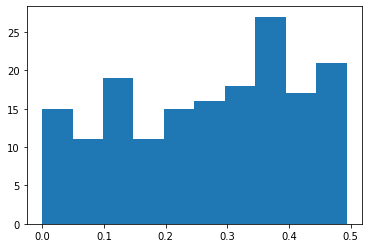

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#np.argwhere((y_test2!=y_hat)&(y_test2==2))
plt.hist(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])
np.mean(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])
y_hat[y_hat_prob[:,2]>np.mean(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])] = 2

In [ ]:
  print(metrics.classification_report(y_test2,y_hat))  


              precision    recall  f1-score   support

           0       0.93      0.90      0.91       982
           1       0.87      0.72      0.79       920
           2       0.84      0.95      0.89      1553

    accuracy                           0.87      3455
   macro avg       0.88      0.85      0.86      3455
weighted avg       0.88      0.87      0.87      3455



In [ ]:
y_hat_prob

array([[0.49, 0.49, 0.02],
       [0.69, 0.24, 0.07],
       [0.73, 0.27, 0.  ],
       ...,
       [0.  , 0.02, 0.98],
       [0.7 , 0.25, 0.05],
       [0.01, 0.53, 0.46]])

In [ ]:
list(zip(list_train[0],list_train[1]))

[('pst.000048738675', 'mdp.39015005828242'),
 ('mdp.39015041138416', 'uc1.$b463115'),
 ('uc1.$b379165', 'txu.059172146813022'),
 ('uc1.l0075260588', 'txu.059173026797569'),
 ('txu.059173012302588', 'uc1.b2870103'),
 ('uc1.b3363605', 'uc1.b4170060'),
 ('ien.35556029819570', 'uc1.31175012502632'),
 ('coo.31924003530924', 'uc1.b3700270'),
 ('uva.x004955720', 'mdp.39015074981138'),
 ('umn.31951t00219388u', 'mdp.39015034923840'),
 ('mdp.39015032015227', 'uc1.$b471030'),
 ('uc1.31822003619731', 'pst.000028986676'),
 ('txu.059173018099738', 'uiug.30112019639472'),
 ('uc1.b4949572', 'mdp.39015075671423'),
 ('mdp.39015069671421', 'inu.30000046388983'),
 ('umn.31951p00438770g', 'mdp.39015035926560'),
 ('mdp.39015059486665', 'uc1.$b690692'),
 ('mdp.39015019764219', 'mdp.39015006568979'),
 ('uc1.b3092461', 'mdp.39015007070504'),
 ('mdp.39015008190939', 'inu.30000115798963'),
 ('uva.x001433125', 'uc1.b4085814'),
 ('inu.30000068587389', 'uc1.31822010436889'),
 ('mdp.39015031447587', 'uc1.b4398726'),

In [ ]:
import tqdm

list_model_rf_en = []
for i,vol_train in enumerate(tqdm.tqdm(list_train)):
  X_train2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)]
  y_train2 = X_train2.type_label.values
  X_train2 = X_train2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()
  X_test2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  X_test2 = X_test2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()

  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                                random_state=0)
  clf_rf.fit(X_train2, y_train2)  
  y_hat = clf_rf.predict(X_test2)
  y_hat_proba = clf_rf.predict_proba(X_test2)
  #metrics.accuracy_score(y_test2,y_hat)
  #print(metrics.classification_report(y_test,y_hat,target_names=type_index))  
  x_local = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False].copy()
  x_local["y_hat"] = y_hat
  x_local["y_hat_prob0"] = y_hat_proba[:,0]
  x_local["y_hat_prob1"] = y_hat_proba[:,1]
  x_local["y_hat_prob2"] = y_hat_proba[:,2]
  x_local["fold"] = i
  list_model_rf_en.append((clf_rf,y_hat,x_local))

100%|██████████| 10/10 [00:48<00:00,  4.80s/it]


In [ ]:
cross_fold = pd.DataFrame()
for x in list_model_rf_en:
  cross_fold = cross_fold.append(x[2][["fold","vol_id","page","y_hat_prob0","y_hat_prob1","y_hat_prob2"]])

In [ ]:
cross_fold.shape

(34633, 6)

In [ ]:
cross_fold.to_csv("output_cross_fold.csv",index=False)

In [ ]:
cross_fold.groupby(["vol_id","page"]).count()

y_hat_prob0  y_hat_prob1  y_hat_prob2
vol_id             page                                       
coo.31924000431662 2               3            3            3
                   3               3            3            3
                   4               3            3            3
                   5               3            3            3
                   6               3            3            3
...                              ...          ...          ...
wu.89103438651     16              3            3            3
                   17              3            3            3
                   18              3            3            3
                   19              3            3            3
                   20              3            3            3

[15353 rows x 3 columns]

In [ ]:
for vol_train,x in zip(list_train,list_model_rf_en):
  X_test2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values

  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       994
           1       0.88      0.85      0.86       991
           2       0.91      0.94      0.92      1472

    accuracy                           0.91      3457
   macro avg       0.91      0.91      0.91      3457
weighted avg       0.91      0.91      0.91      3457

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       931
           1       0.85      0.85      0.85       988
           2       0.91      0.91      0.91      1533

    accuracy                           0.90      3452
   macro avg       0.90      0.89      0.90      3452
weighted avg       0.90      0.90      0.90      3452

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1006
           1       0.87      0.82      0.85      1011
           2       0.90      0.92      0.91      1456

    accuracy        

# Risk Analysis

In [ ]:
pct_error = []

for x in list_model_rf:
  loc_x = x[2]
  for x in loc_x.vol_id.unique():
    #vol_pct = []
    llx = loc_x.groupby("vol_id").get_group(x)
    #tot_creative = llx[llx.type_label==2].shape[0]
    #tot_error = llx[(llx.type_label==2)&(llx.y_hat!=2)].shape[0]
    tot_creative = llx.shape[0]
    tot_error = llx[(llx.type_label==2)&(llx.y_hat!=2)].shape[0]    
    pct = 0
    if tot_creative > 0:
      pct = tot_error/tot_creative
    pct_error.append(pct)
    #break    
  #pct_error.append(np.mean(vol_pct))
  #break

In [ ]:
np.mean(pct_error)

0.05772244897959184

In [ ]:
list_model_rf_en[0]

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=20, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=200,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 array([1, 0, 0, ..., 2, 2, 2]),
                    vol_id  page      type_x  ... cover music_score  y_hat
 59     coo.31924073896007     1     factual  ...   0.0         0.0      1
 60     coo.31924073896007     2  no_content  ...   0.0         0.0      0
 61     coo.31924073896007     3  no_content  ...   0.0         0.0      0
 62     coo.31924073896007     4  no_content  ...   0.0         0.0      0
 63     coo.31924073896007     5  no_cont

In [ ]:
pct_error = []

#for x in [list_model_rf_en[0]]:
for x in list_model_rf_en:
  loc_x = x[2]
  for x in loc_x.vol_id.unique():
    #vol_pct = []
    llx = loc_x.groupby("vol_id").get_group(x)
    #tot_creative = llx[llx.type_label==2].shape[0]
    #tot_error = llx[(llx.type_label==2)&(llx.y_hat!=2)].shape[0]
    #tot_creative = llx[(llx.type_label==2)&(llx.page<=10)].shape[0]
    tot_creative = llx.shape[0]
    tot_error = llx[(llx.type_label==2)&(llx.y_hat!=2)].shape[0]
    #tot_error = llx[(llx.type_label==2)&(llx.y_hat!=2)&(llx.page<=10)].shape[0]    
    pct = 0
    if tot_creative > 0:
      pct = tot_error/tot_creative
    pct_error.append(pct)
    #break    
  #pct_error.append(np.mean(vol_pct))
  #break

In [ ]:
np.mean(pct_error)

0.03993034371643394

In [ ]:
tot_creative,tot_error

(4, 0)

In [ ]:
import tqdm
import numpy as np

list_model_rf_en = []
error_prob = []
for vol_train in tqdm.tqdm(list_train):
  X_train2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)]
  y_train2 = X_train2.type_label.values
  X_train2 = X_train2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()
  X_test2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  X_test2 = X_test2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","image","no_content","text","cover","music_score"]].to_numpy()

  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                                random_state=0)
  clf_rf.fit(X_train2, y_train2)  
  y_hat = clf_rf.predict(X_test2)
  #metrics.accuracy_score(y_test2,y_hat)
  #print(metrics.classification_report(y_test,y_hat,target_names=type_index))  
  y_hat_prob = clf_rf.predict_proba(X_test2)
  error_prob.extend(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])
  y_hat[y_hat_prob[:,2]>np.mean(y_hat_prob[(y_test2!=y_hat)&(y_test2==2)][:,2])] = 2
  list_model_rf_en.append((clf_rf,y_hat))

100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


# Confusion Matrix

In [ ]:
vol_train

'uc1.b3019605'

In [ ]:
len(list_train),len(list_model_rf)

(10, 10)

In [ ]:
list_train[6]

['uc1.b3019605',
 'coo.31924094241217',
 'mdp.39015000443450',
 'pst.000014221668',
 'wu.89090640525',
 'pst.000028986676',
 'inu.30000068246549',
 'pst.000059278467',
 'mdp.39015048360492',
 'inu.30000004501700',
 'mdp.39015008190939',
 'mdp.39015000502024',
 'uc1.31175012502632',
 'umn.31951d01046615s',
 'ien.35556008335218',
 'umn.31951p00438770g',
 'uc1.$b686011',
 'uc1.b3290161',
 'mdp.39015062118842',
 'mdp.39015021933406',
 'txu.059173018072390',
 'coo.31924002110280',
 'uiug.30112118501086',
 'inu.39000001130074',
 'pst.000062623544',
 'ien.35558005581034',
 'uc1.c103070885',
 'mdp.39015085088683',
 'inu.30000042834030',
 'uva.x030688122',
 'mdp.39015065264809',
 'txu.059173026662060',
 'mdp.39015022458486',
 'chi.40727635',
 'uc1.b3421165',
 'mdp.39015082045694',
 'uc1.l0063648034',
 'uc1.b2852274',
 'uc1.b4350250',
 'uc1.b3297401',
 'mdp.39015057524889',
 'ien.35558000991931',
 'mdp.39015005096782',
 'coo.31924061389486',
 'uc1.32106001347340',
 'uc1.c059195501',
 'mdp.390150

In [ ]:
for vol_train,x in zip([list_train[5]],[list_model_rf[5]]):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values

  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       993
           1       0.76      0.79      0.77       877
           2       0.90      0.84      0.87      1606

    accuracy                           0.84      3476
   macro avg       0.83      0.84      0.84      3476
weighted avg       0.85      0.84      0.85      3476



array([0, 1, 0, ..., 2, 0, 1])

In [ ]:
ok_do = tt[tt.vol_id.isin(vol_train)==False].copy().reset_index()

In [ ]:
ok_do["pred"] = x[1]

In [ ]:
re_define = {
	"ad": "image",
	"appendix": "text",
	"cover": "cover",
	"dedication": "text",
	"epigraph": "text",
	"image": "image",
	"list": "text",
	"main_text": "text",
	"music_score": "music_score",
	"no_content": "no_content",
	"poem": "text",
	"pref_text": "text",
	"pub_info": "text",
	"title": "cover"
}

In [ ]:
ok_do["re_define"] = ok_do.sub_type.apply(lambda x:re_define[x])

In [ ]:
ok_do[ok_do.type_label!=ok_do.pred].groupby(["type","pred","re_define"]).count()

index  vol_id  ...  pct_roman  type_label
type       pred re_define                  ...                       
creative   0    cover          28      28  ...         28          28
                image          55      55  ...         55          55
                text           10      10  ...         10          10
           1    cover          16      16  ...         16          16
                image          42      42  ...         42          42
                text          105     105  ...        105         105
factual    0    cover          60      60  ...         60          60
                image           5       5  ...          5           5
                text           13      13  ...         13          13
           2    cover          19      19  ...         19          19
                image          13      13  ...         13          13
                text           77      77  ...         77          77
no_content 1    no_content     52      52  ...         52          52
           2    no_content     45      45  ...         45          45

[14 rows x 16 columns]

# Analyze Error

In [ ]:
for vol_train,x in zip([list_train[5]],[list_model_rf[5]]):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values

  print(metrics.classification_report(y_test2,x[1]))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       993
           1       0.76      0.79      0.77       877
           2       0.90      0.84      0.87      1606

    accuracy                           0.84      3476
   macro avg       0.83      0.84      0.84      3476
weighted avg       0.85      0.84      0.85      3476



In [ ]:
error_pd_normal = pd.DataFrame()
for i,(vol_train,x) in enumerate(zip(list_train,list_model_rf)):
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values  

  print(metrics.classification_report(y_test2,x[1]))
  ok_do = tt[tt.vol_id.isin(vol_train)==False].copy().reset_index()  
  ok_do["pred"] = x[1]
  ok_do["re_define"] = ok_do.sub_type.apply(lambda x:re_define[x])
  ok_do["test_list"] = i
  error_pd_normal = error_pd_normal.append(ok_do)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1016
           1       0.85      0.80      0.83       992
           2       0.89      0.91      0.90      1472

    accuracy                           0.88      3480
   macro avg       0.88      0.88      0.88      3480
weighted avg       0.88      0.88      0.88      3480

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       952
           1       0.82      0.81      0.82       994
           2       0.90      0.88      0.89      1534

    accuracy                           0.87      3480
   macro avg       0.86      0.87      0.86      3480
weighted avg       0.87      0.87      0.87      3480

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1029
           1       0.84      0.77      0.81      1013
           2       0.88      0.88      0.88      1458

    accuracy        

In [ ]:
error_analysis_normal = error_pd_normal[error_pd_normal.type_label!=error_pd_normal.pred].groupby(["type","pred","re_define"]).count()[["index"]].reset_index()
error_analysis_normal = error_analysis_normal[error_analysis_normal.type=="creative"]

In [ ]:
error_analysis_normal["perc"] = error_analysis_normal["index"] /  error_analysis_normal["index"].sum()

In [ ]:
error_analysis_normal

,type,pred,re_define,index,perc
0,creative,0,cover,245,0.122012
1,creative,0,image,431,0.214641
2,creative,0,text,142,0.070717
3,creative,1,cover,183,0.091135
4,creative,1,image,302,0.150398
5,creative,1,text,705,0.351096


In [ ]:
ok_do = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False].copy().reset_index()

In [ ]:
ok_do["pred"] = x[1]

In [ ]:
re_define = {
	"ad": "image",
	"appendix": "text",
	"cover": "cover",
	"dedication": "text",
	"epigraph": "text",
	"image": "image",
	"list": "text",
	"main_text": "text",
	"music_score": "music_score",
	"no_content": "no_content",
	"poem": "text",
	"pref_text": "text",
	"pub_info": "text",
	"title": "cover"
}

In [ ]:
ok_do

,index,vol_id,page,type_x,sub_type_x,add_x,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman,type_label,type_y,sub_type_y,add_y,type_index,re_define,0,1,2,file,image,no_content,text,cover,music_score,pred
0,20,coo.31924000431662,2,no_content,no_content,"barcode, due date slip",9,28,1,8,6,0,0.750000,0.000000,0.428571,0.928571,0,no_content,no_content,"barcode, due date slip",0,no_content,/N/slate/ninoparu/extracted_images/31924000431...,coo.31924000431662,2,/N/slate/ninoparu/extracted_images/31924000431...,0.000000,0.020515,0.000000,0.000000,0.000000,1
1,21,coo.31924000431662,3,factual,title,,18,97,1,17,13,2,0.764706,0.117647,0.711340,0.773196,1,factual,title,0,1,cover,/N/slate/ninoparu/extracted_images/31924000431...,coo.31924000431662,3,/N/slate/ninoparu/extracted_images/31924000431...,0.036248,0.000000,0.135856,0.057910,0.000000,1
2,22,coo.31924000431662,4,factual,pub_info,,13,119,0,13,7,1,0.538462,0.076923,0.025210,0.705882,1,factual,pub_info,0,2,text,/N/slate/ninoparu/extracted_images/31924000431...,coo.31924000431662,4,/N/slate/ninoparu/extracted_images/31924000431...,0.000000,0.035046,0.000000,0.000000,0.000000,1
3,23,coo.31924000431662,5,factual,list,,28,178,0,28,20,9,0.714286,0.321429,0.078652,0.634831,1,factual,list,0,3,text,/N/slate/ninoparu/extracted_images/31924000431...,coo.31924000431662,5,/N/slate/ninoparu/extracted_images/31924000431...,0.035062,0.000000,0.131122,0.062674,0.000000,1
4,24,coo.31924000431662,6,no_content,no_content,,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,no_content,no_content,0,0,no_content,/N/slate/ninoparu/extracted_images/31924000431...,coo.31924000431662,6,/N/slate/ninoparu/extracted_images/31924000431...,0.000000,0.029121,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3452,17018,uc1.$b796241,16,factual,ad,,30,137,1,29,22,1,0.758621,0.034483,0.218978,0.708029,1,factual,ad,0,7,image,/N/slate/ninoparu/extracted_images/$b796241/UC...,uc1.$b796241,16,/N/slate/ninoparu/extracted_images/$b796241/UC...,0.099167,0.028409,0.064552,0.033764,0.045983,1
3453,17019,uc1.$b796241,17,creative,main_text,,37,358,1,36,14,1,0.388889,0.027778,0.044693,0.639665,2,creative,main_text,0,4,text,/N/slate/ninoparu/extracted_images/$b796241/UC...,uc1.$b796241,17,/N/slate/ninoparu/extracted_images/$b796241/UC...,0.133894,0.014814,0.178375,0.000000,0.000000,2
3454,17020,uc1.$b796241,18,creative,main_text,,40,482,0,40,3,0,0.075000,0.000000,0.004149,0.545643,2,creative,main_text,0,4,text,/N/slate/ninoparu/extracted_images/$b796241/UC...,uc1.$b796241,18,/N/slate/ninoparu/extracted_images/$b796241/UC...,0.085596,0.017253,0.423570,0.000000,0.000000,2
3455,17021,uc1.$b796241,19,creative,main_text,,40,488,0,40,5,0,0.125000,0.000000,0.000000,0.508197,2,creative,main_text,0,4,text,/N/slate/ninoparu/extracted_images/$b796241/UC...,uc1.$b796241,19,/N/slate/ninoparu/extracted_images/$b796241/UC...,0.070409,0.014164,0.273205,0.000000,0.000000,2


In [ ]:
ok_do["re_define"] = ok_do.sub_type_x.apply(lambda x:re_define[x])

In [ ]:
ok_do[ok_do.type_label!=ok_do.pred].groupby(["type_x","pred","re_define"]).count()

index  vol_id  page  ...  text  cover  music_score
type_x     pred re_define                        ...                          
creative   0    cover           7       7     7  ...     7      7            7
                image          25      25    25  ...    25     25           25
                text            3       3     3  ...     3      3            3
           1    cover          16      16    16  ...    16     16           16
                image          20      20    20  ...    20     20           20
                text          100     100   100  ...   100    100          100
factual    0    cover          22      22    22  ...    22     22           22
                image           2       2     2  ...     2      2            2
                text           17      17    17  ...    17     17           17
           2    cover          17      17    17  ...    17     17           17
                image          17      17    17  ...    17     17           17
                text           69      69    69  ...    69     69           69
no_content 1    no_content     39      39    39  ...    39     39           39
           2    no_content     28      28    28  ...    28     28           28

[14 rows x 29 columns]

# Analyze Error

In [ ]:
error_pd_ensemble = pd.DataFrame()
for i,(vol_train,x) in enumerate(zip(list_train,list_model_rf_en)):
  X_test2 = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values  

  if i == 0:
    cnf_matrix = confusion_matrix(y_test2,x[1])
  else:
    cnf_matrix += confusion_matrix(y_test2,x[1])

  print(metrics.classification_report(y_test2,x[1]))
  ok_do = x_fact_en[x_fact_en.vol_id.isin(vol_train)==False].copy().reset_index()  
  ok_do["pred"] = x[1]
  ok_do["re_define"] = ok_do.sub_type_x.apply(lambda x:re_define[x])
  ok_do["test_list"] = i
  error_pd_ensemble = error_pd_ensemble.append(ok_do)  

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       994
           1       0.92      0.75      0.83       991
           2       0.85      0.97      0.91      1472

    accuracy                           0.89      3457
   macro avg       0.90      0.88      0.89      3457
weighted avg       0.90      0.89      0.89      3457

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       931
           1       0.90      0.74      0.82       988
           2       0.85      0.96      0.90      1533

    accuracy                           0.88      3452
   macro avg       0.89      0.87      0.88      3452
weighted avg       0.89      0.88      0.88      3452

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1006
           1       0.91      0.70      0.79      1011
           2       0.82      0.96      0.88      1456

    accuracy        

Normalized confusion matrix


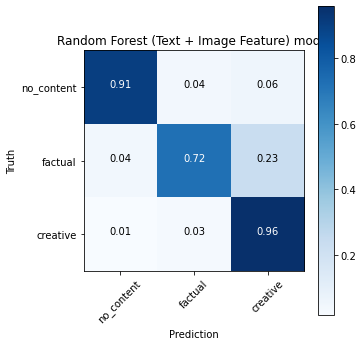

In [ ]:
import numpy as np
#cnf_matrix = confusion_matrix(y_test3,y_hat3)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=x_fact_en.type_x.unique().tolist(), normalize=True,
                      title="{} model".format("Random Forest (Text + Image Feature)"))
plt.savefig("rf-ensemble.pdf",bbox_inches="tight")


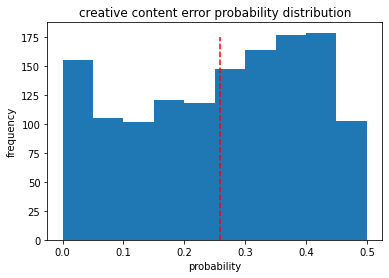

In [ ]:
plt.hist(error_prob)
plt.title("creative content error probability distribution")
plt.xlabel("probability")
plt.ylabel("frequency")
plt.vlines(np.mean(error_prob),ymin=0,ymax=175,linestyles="dashed",color="red")

In [ ]:
np.mean(error_prob),np.max(error_prob),np.std(error_prob)

(0.2588367097732413, 0.4997612612612613, 0.1438145118076262)

In [ ]:
error_analysis_ensemble = error_pd_ensemble[error_pd_ensemble.type_label!=error_pd_ensemble.pred].groupby(["type_x","pred","re_define"]).count()[["index"]].reset_index()
error_analysis_ensemble = error_analysis_ensemble[error_analysis_ensemble.type_x=="creative"]

In [ ]:
error_analysis_ensemble["perc"] = error_analysis_ensemble["index"] /  error_analysis_ensemble["index"].sum()

In [ ]:
error_analysis_ensemble

,type_x,pred,re_define,index,perc
0,creative,0,cover,48,0.034985
1,creative,0,image,204,0.148688
2,creative,0,text,54,0.039359
3,creative,1,cover,177,0.129009
4,creative,1,image,189,0.137755
5,creative,1,text,700,0.510204


In [ ]:
error_analysis_normal

,type,pred,re_define,index,perc
0,creative,0,cover,245,0.122012
1,creative,0,image,431,0.214641
2,creative,0,text,142,0.070717
3,creative,1,cover,183,0.091135
4,creative,1,image,302,0.150398
5,creative,1,text,705,0.351096


In [ ]:
  X_train2 = tt[tt.vol_id.isin(vol_train)]
  y_train2 = X_train2.type_label.values
  X_train2 = X_train2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]].to_numpy()
  X_test2 = tt[tt.vol_id.isin(vol_train)==False]
  y_test2 = X_test2.type_label.values
  X_test2 = X_test2[["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]].to_numpy()

  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                                random_state=0)
  clf_rf.fit(X_train2, y_train2)  
  y_hat = clf_rf.predict(X_test2)